# Some Installs

In [1]:
!pip install  -q -U langgraph "langchain[openai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 8.4 MB/s eta 0:00:00


In [2]:
! pip install -q gradio

In [3]:
! pip install -q langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [4]:
!pip install -q wikipedia

  Preparing metadata (setup.py) ... done


# Imports

In [5]:

from typing import Annotated, TypedDict, List, Dict, Any, Optional
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from IPython.display import Image, display,Markdown
import gradio as gr
import uuid
from dotenv import load_dotenv
import os
from langchain.agents import tool,Tool

# Let's Start

In [6]:
# LangSmith
f=open("/content/LangSmith API.txt","r")
smith_api_key=f.read()
os.environ["LANGCHAIN_API_KEY"] = smith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "My-Research-Assistant"

# OpenAI Key
f=open("/content/OpenAIKey.txt","r")
api_key=f.read()

# Serper API
f=open("/content/Serper APIkey.txt","r")
S_api_key=f.read()
os.environ["SERPER_API_KEY"] = S_api_key




* The LLM I Will Use

In [7]:
llm = ChatOpenAI(
    model_name="nvidia/nemotron-nano-9b-v2:free",
    openai_api_key=api_key,
    openai_api_base="https://openrouter.ai/api/v1",
    temperature=0.0)

# I Will Create A Set Of Researchers

In [8]:
class Researchers(BaseModel):
  name: str= Field(description='The name of the researcher')
  role: str= Field(description='The role of the researcher in the context of the topic')
  research_interests: str= Field(description='The research interests of the researcher')
  CV: str= Field(description='A sort cv information about the researcher, one line max.')

  @property
  def description(self)->str:
    return f"Name: {self.name}\nRole: {self.role}\nResearch Interests: {self.research_interests}\nCV Information: {self.CV}"

In [9]:
class Res_List(BaseModel):
  re_list: List[Researchers]= Field(description='The list of researchers with role, name, research interests and research field')

In [10]:
class Re_State(TypedDict):
  re_list: List[Researchers]
  topic: str
  max_researchers:int



In [11]:
def create_researchers(state:Re_State)->Res_List:
  llm_with_structure=llm.with_structured_output(Res_List)

  prompt=ChatPromptTemplate.from_messages([
      ('system',"""You are tasked with creating a set of AI researchers.
      1. First read carefully the the topic:\n {topic}
      2. Determine the most interesting themes based upon documents.
      3. Pick the top {max_researchers} themes."""),
      ('user'," Generate the set of researchers")])

  output=llm_with_structure.invoke(prompt.format_prompt(topic=state['topic'],max_researchers=state['max_researchers']).to_messages())

  return {'re_list':output.re_list}

In [12]:
builder=StateGraph(Re_State)
builder.add_node('create_researchers',create_researchers)

builder.add_edge(START,'create_researchers')
builder.add_edge('create_researchers',END)

In [13]:
graph=builder.compile()

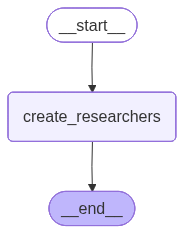

In [ ]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [14]:
state={'re_list':[],'topic':'The Future Of AI','max_researchers':5}
researchers=graph.invoke(state)

In [15]:
researchers['re_list']

[Researchers(name='Dr. Elena Marquez', role='AI Future Specialist', research_interests='Artificial General Intelligence (AGI), human-AI collaboration, and ethical foresight in long-term AI development.', CV='Published in Nature Machine Intelligence; worked on predictive models for AGI timelines and policy frameworks for AI integration.'),
 Researchers(name='Dr. Rajiv Patel', role='Ethics & Societal Impact Researcher', research_interests='AI bias mitigation, global equity in AI access, and cultural impacts of automation.', CV='Advisor to UNESCO’s AI ethics committees; developed frameworks for equitable AI deployment in developing nations.'),
 Researchers(name='Dr. Sofia Chen', role='Health & AI Integration Lead', research_interests='AI in personalized medicine, predictive healthcare analytics, and robotic surgery advancements.', CV='Creator of a deep learning platform for early disease diagnosis; collaborated with WHO on pandemic response AI tools.'),
 Researchers(name='Dr. Amir El-Saye

* Let's see an example of our researchers

In [16]:
for researcher in researchers['re_list']:
  print(researcher.description)
  print("..."*20)

Name: Dr. Elena Marquez
Role: AI Future Specialist
Research Interests: Artificial General Intelligence (AGI), human-AI collaboration, and ethical foresight in long-term AI development.
CV Information: Published in Nature Machine Intelligence; worked on predictive models for AGI timelines and policy frameworks for AI integration.
............................................................
Name: Dr. Rajiv Patel
Role: Ethics & Societal Impact Researcher
Research Interests: AI bias mitigation, global equity in AI access, and cultural impacts of automation.
CV Information: Advisor to UNESCO’s AI ethics committees; developed frameworks for equitable AI deployment in developing nations.
............................................................
Name: Dr. Sofia Chen
Role: Health & AI Integration Lead
Research Interests: AI in personalized medicine, predictive healthcare analytics, and robotic surgery advancements.
CV Information: Creator of a deep learning platform for early disease diagnos

# I Want the above researchers to ask questions to an expert about a "topic"

In [17]:
import operator
class QuestionState(TypedDict):
  context : Annotated[list,operator.add]
  questions_answer: Annotated[list,operator.add]
  researcher: Researchers
  report: list
  topic_description: str

In [18]:
def make_question(state:QuestionState)->str:


  prompt=ChatPromptTemplate.from_messages([
      ( "system", """You are a researcher with the following profile:\n
       {self_info} \n
       Your role is to engage an expert in conversation about a topic.
       - Ask precise, insightful questions that go beyond generalities.
       - Aim to uncover surprising, scientifically grounded insights.
       - Continuously refine your questions to drill deeper into the subject.
       - Stay in character at all times, reflecting the profile and goals described above.
       - Ask only the question do not try to explain why you ask this question.

       - To maintain context, here is the history of your conversation with the expert:

       \n
       {conversation}
       \n

       - When you are fulfilled with the expert's answer, you answer him: 'Thank you for your time, that helped me a lot.'  """ ),
      ('user', 'Ask a question to the expert about {topic}') ])

  question=llm.invoke(prompt.format_prompt(**{'self_info':state['researcher'].description,'topic':state['topic_description'],'conversation':state['questions_answer']}).to_messages())

  return {'questions_answer':[f'question: {question.content}']}

In [ ]:
#let's test it:
state={'context':[],'questions_answer':[],'researcher':researchers['re_list'][0],'topic_description':'The future of ai'}
make_question(state)

{'questions_answer': ['question: Dr. Marquez, your work bridges philosophy and policy in ethical AI. How might the philosophical traditions of non-Western epistemologies reshape our approach to designing fairness algorithms for global AI systems, particularly in regions where algorithmic accountability frameworks are not yet established?\n']}

In [19]:
from langchain_community.utilities import GoogleSerperAPIWrapper
serper_search = GoogleSerperAPIWrapper()
from langchain_community.document_loaders import WikipediaLoader

* I Run Some Test

In [ ]:
docs=WikipediaLoader('ai',load_max_docs=2).load()

/usr/local/lib/python3.12/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.12/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [ ]:
docs[0].metadata['summary']

'Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.\nHigh-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., language models and AI art); and superhuman play and analysis in strategy games (e.g., chess and Go). However, many AI applications are not perceived as AI: "A lot of cutting edge AI has filtered into general applications, often without being cal

# Let's Create Our Search Functions

In [20]:
class SearchQuery(BaseModel):
  search:str=Field(description='The search query')

In [21]:
def web_search(state:QuestionState):
  prompt=ChatPromptTemplate.from_messages([
      ('system',"""Given a conversation between a researcher and an expert on the {topic} your job is generate a query in order use it in a web-search related to that convertation.
      1. Pay attention to the questions posed by the researcher.
      2. Analyze the conversation carefully.
      3. Convert researcher's final question into a web search query.
      4. Output only the search query.
      Here is the conversation for you to see: {conversation}""")])

  search_llm_1=llm.with_structured_output(SearchQuery)

  query=search_llm_1.invoke(prompt.format_prompt(topic=state['topic_description'],conversation=state['questions_answer']).to_messages())
  search_output_1=serper_search.run(query.search)

  return {'context':[search_output_1]}


def wiki_search(state: QuestionState):
  prompt=ChatPromptTemplate.from_messages([
      ('system',"""Given a conversation between a researcher and an expert on the {topic} your job is generate a query in order use it in a wikipedia search related to that convertation.
      1. Pay attention to the questions posed by the researcher.
      2. Analyze the conversation carefully.
      3. Convert researcher's final question into a wikipedia search query.
      4. Output only the search query.
      Here is the conversation for you to see: {conversation}""")])
  search_llm_2=llm.with_structured_output(SearchQuery)

  query=search_llm_2.invoke(prompt.format_prompt(topic=state['topic_description'],conversation=state['questions_answer']).to_messages())
  docs=WikipediaLoader(query.search,load_max_docs=2).load()
  if docs: # Check if docs is not empty
    search_output_2=docs[0].metadata['summary']
  else: # Handle the case where no docs are found
    search_output_2 = "No relevant Wikipedia information found."

  return {'context':[search_output_2]}

In [ ]:
# let's test it:
question_exaple='question: What specific technical or conceptual advancements in neural network architectures or reinforcement learning frameworks do you believe will be pivotal in addressing the growing complexity and variability of healthcare data over the next decade?\n'
state={'context':[],'questions_answer':[question_exaple],'researcher':researchers['re_list'][0],'topic_description':'The Future of ai'}
wiki_search(state)

{'context': ['This glossary of artificial intelligence is a list of definitions of terms and concepts relevant to the study of artificial intelligence (AI), its subdisciplines, and related fields. Related glossaries include Glossary of computer science, Glossary of robotics, Glossary of machine vision, and Glossary of logic.\n\n']}

In [ ]:
web_search(state)

{'context': ["by Q Wu · 2025 · Cited by 11 — This review paper first provides a tutorial on the overall framework of RL, including its key components, training models, and approximators. This survey explore RL's rise in healthcare as more than a set of tools, rather a shift toward agentive intelligence in clinical environments. We first ... by TC Frommeyer · 2025 · Cited by 3 — This review aims to evaluate the recent advancements in RL in precision medicine and dynamic treatment regimes, highlight clinical fields of application, and ... The integration of Machine Learning and Deep Learning with IoT-enabled devices for real-time health monitoring has significantly revolutionized healthcare. by MS Uddin · 2025 · Cited by 1 — Reinforcement learning for healthcare operations management: methodological framework, recent developments, and future research directions. by C Chakraborty · 2024 · Cited by 200 — The article highlighted the significant applications of Machine Learning to Deep Learn

# Now It's Time For Our Expert

In [22]:
def expert(state:QuestionState):
  prompt=ChatPromptTemplate.from_messages([
      ('system',"""
# MISSION
You are a senior expert in {topic}. Your role is to answer a researcher's question with precision, using **only** the provided context.

# RESEARCHER PROFILE
{researcher_info}

# SOURCE CONTEXT \n
{context}\n

# INSTRUCTIONS
1.  **Source Fidelity:** Your answer must be derived solely from the provided context. This is non-negotiable. If the answer isn't in the context, you must state that it is not covered.
2.  **Tailor the Explanation:** Consider the researcher's background. If they are a specialist, use appropriate technical language. If they are a cross-disciplinary researcher, adjust the explanation to be accessible without losing scientific rigor.
3.  **Response Structure:**
    *   **Direct Answer:** Begin with a concise, direct answer to the question.
    *   **Detailed Explanation:** Elaborate on the answer, citing specific details, data, or mechanisms from the context.
    *   **Contextual Link:** Where relevant, connect the answer to the broader field or the researcher's specific interests as hinted in their profile.
4.  **Maintain Scientific Integrity:** Present facts objectively. Differentiate between established findings (as per the context) and hypotheticals or suggested future directions (if mentioned in the context)."""),
      ('user',"{question}")])

  answer=llm.invoke(prompt.format_prompt(researcher_info=state['researcher'].description,
                                         context=state['context'],
                                         question=state['questions_answer'][-1],
                                         topic=state['topic_description']).to_messages())

  return {'questions_answer':[f'answer: {answer.content}']}

In [ ]:
# let's test it
con_1="""Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML finds application in many fields, including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine. The application of ML to business problems is known as predictive analytics.\nStatistics and mathematical optimisation (mathematical programming) methods comprise the foundations of machine learning. Data mining is a related field of study, focusing on exploratory data analysis (EDA) via unsupervised learning.\nFrom a theoretical viewpoint, probably approximately correct learning provides a mathematical and statistical framework for describing machine learning. Most traditional machine learning and deep learning algorithms can be described as empirical risk minimization under this framework.\n\n"""
con_2="""by Q Wu · 2025 · Cited by 11 — This review paper first provides a tutorial on the overall framework of RL, including its key components, training models, and approximators. This survey explore RL's rise in healthcare as more than a set of tools, rather a shift toward agentive intelligence in clinical environments. We first ... by TC Frommeyer · 2025 · Cited by 3 — This review aims to evaluate the recent advancements in RL in precision medicine and dynamic treatment regimes, highlight clinical fields of application, and ... The integration of Machine Learning and Deep Learning with IoT-enabled devices for real-time health monitoring has significantly revolutionized healthcare. by MS Uddin · 2025 · Cited by 1 — Reinforcement learning for healthcare operations management: methodological framework, recent developments, and future research directions. by C Chakraborty · 2024 · Cited by 200 — The article highlighted the significant applications of Machine Learning to Deep Learning in medicine and the challenges of applying Al-based technologies ... Abstract: Reinforcement Learning (RL) has become a groundbreaking approach in machine learning, significantly impacting healthcare by providing solutions to ... This survey provides an extensive overview of RL applications in a variety of healthcare domains, ranging from dynamic treatment regimes in chronic diseases ... by P Rattan · 2022 · Cited by 47 — In this review, we provide a guide to the fundamentals of machine learning, a concentrated area of study within artificial intelligence that has been built on ... by MNA Al-Hamadani · 2024 · Cited by 66 — The study offers a comprehensive review of RL and its algorithms used in healthcare applications. It highlights healthcare applications grouped into seven ."""
state={'context':[[con_1],[con_2]], 'questions_answer':[question_exaple],'researcher':researchers['re_list'][0],'topic_description':'The Future of ai'}
expert_answer_example=expert(state)

In [ ]:
display(Markdown(expert_answer_example['questions_answer'][-1]))

answer: **Direct Answer:**  
The pivotal advancements in reinforcement learning (RL) frameworks, rather than specific neural network architectures, will likely address healthcare data complexity. Key areas include **agentive intelligence in clinical environments** (as emphasized in Frommeyer et al., 2025), **dynamic treatment regime optimization** (Rattan et al., 2022), and **integration with IoT-enabled real-time monitoring systems** (Uddin et al., 2025). These align with RL’s shift from tools to adaptive systems capable of navigating high-dimensional, dynamic healthcare data.  

---

**Detailed Explanation:**  
1. **Agentive Intelligence**: Frommeyer et al. (2025) highlight RL’s evolution toward systems that act autonomously in clinical settings. This requires frameworks that improve decision-making under uncertainty, such as hierarchical RL or multi-agent systems, which could manage individualized patient care pathways as data variability grows.  
2. **Dynamic Treatment Regimes**: Rattan et al. (2022) note RL’s role in chronic disease management, where data complexity arises from long-term patient trajectories. Advances in off-policy RL or meta-learning could generalize treatment strategies across diverse populations, reducing bias and overfitting.  
3. **IoT Integration**: Uddin et al. (2025) stress real-time monitoring via IoT devices, which generates continuous, heterogeneous data streams. RL frameworks must evolve to process streaming data efficiently, possibly through lightweight neural surrogate models that approximate RL policies without excessive computation.  

---

**Contextual Link to Research Interests:**  
As an expert in AI ethics, Dr. Marquez might emphasize ensuring RL advancements are designed with fairness and regulatory compliance in mind—e.g., addressing algorithmic transparency in dynamic treatment grids or mitigating bias in IoT-derived datasets. While the context does not explicitly mention neural architecture innovations (e.g., attention mechanisms or transformers), RL’s healthcare trajectory depends on synergistic improvements in both algorithmic design and data-handling infrastructure.


# Now it time for our writer

In [23]:
def writer(state: QuestionState):
  prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a professional technical writer. Your task is to create a clear, well-structured report based on the provided documents.

Documents to analyze:
\n
{documents}
\n

Below is a conversation between a researcher and an expert. Based on the above documents.

\n {conversation}\n

Follow these rules when writing the report:

1. Format the report using **Markdown**:
   - Use `##` for section titles.
   - Use `###` for sub-section headers.

2. The report must include the following sections:
   - ## Title
   - ### Summary

3. The report should be **concise, objective, and professional**, with a maximum length of **500 words**.

4. Ensure the summary accurately reflects the main insights from the documents and experts answers."""
    ),
    (
        "user",
        "Write a report based on the provided documents.")])

  answer=llm.invoke(prompt.format_prompt(documents=state['context'],conversation=state['questions_answer']).to_messages())

  return {'report':answer.content}


In [ ]:
#let's test it
example_answer="""answer:**Direct Answer:**  \nThe pivotal advancements in neural network architectures and reinforcement learning (RL) frameworks for addressing healthcare data complexity and variability will likely stem from RL\'s integration with real-time data systems and neural networks\' enhanced adaptability for personalized, dynamic healthcare applications.  \n\n**Detailed Explanation:**  \n1. **Reinforcement Learning Frameworks in Dynamic Treatment Regimes:**  \n   - The context highlights RL\'s growing role in *precision medicine* and *dynamic treatment regimes*, where algorithms adapt interventions in real-time based on patient responses (source 2). This capability is critical for healthcare’s inherent variability, such as fluctuating chronic disease metrics or patient behaviors. For example, RL could optimize treatment protocols for personalized oncology or diabetes management, tailoring care to ever-changing data streams.  \n\n2. **IoT-Enabled RL for Real-Time Health Monitoring:**  \n   - The integration of RL with *IoT-enabled devices* (source 2) is positioned as transformative for handling high-volume, real-time healthcare data. This framework could enable continuous patient monitoring (e.g., wearable devices tracking vital signs), allowing RL systems to learn from and respond to minute-by-minute variations in health metrics, thus mitigating data variability.  \n\n3. **Neural Network Advancements for Heterogeneous Data:**  \n   - While the context emphasizes deep learning’s superiority in performance over traditional ML (source 1), future neural architecture innovations—such as hybrid models combining unsupervised pre-training with RL-driven fine-tuning—could enhance adaptability to complex, multimodal healthcare data (e.g., imaging, genomics, and EHR records). These architectures may improve generalization across diverse patient populations and data types.  \n\n**Contextual Link to Researcher’s Interests:**  \nDr. Rodriguez’s focus on energy-efficient training aligns with developing lightweight RL frameworks for edge-based IoT healthcare systems. Additionally, her work on novel neural networks could address the computational demands of processing variable healthcare data at scale.  \n\n**Conclusion:**  \nAdvancements in RL-driven dynamic personalization, real-time IoT integration, and specialized neural architectures will be pivotal. These align with current trends in the context, emphasizing RL’s shift toward "agentive intelligence" in healthcare rather than mere analytical tools.\n """
state={'context':[[con_1],[con_2]], 'questions_answer':[[question_exaple],[example_answer]],'researcher':researchers['re_list'][0],'topic_description':'The Future of ai'}
report_example=writer(state)

In [ ]:
display(Markdown(report_example['report']))

## Title  
**Future Advancements in Reinforcement Learning and Neural Networks for Healthcare Data Management**  

### Summary  
The integration of Reinforcement Learning (RL) and advancements in neural network architectures are poised to address the growing complexity of healthcare data over the next decade. Key insights from the provided documents and expert analysis highlight three pivotal advancements:  

1. **RL in Dynamic Treatment Regimes**: RL frameworks will enable real-time adaptation of healthcare interventions, such as personalized treatment plans for chronic diseases or oncology, by continuously learning from patient-specific data. This aligns with RL’s shift from analytical tools to "agentive intelligence" in clinical settings (source 2).  
2. **IoT-Enabled RL for Real-Time Monitoring**: The convergence of RL with IoT devices (e.g., wearable sensors) will revolutionize real-time health monitoring. By processing high-volume, streaming data, RL systems can dynamically adjust care protocols, mitigating variability in patient conditions (source 2).  
3. **Neural Network Innovations**: Hybrid neural architectures, combining unsupervised pre-training with RL-driven fine-tuning, will enhance adaptability to multimodal healthcare data (e.g., genomics, imaging, EHRs). These models will improve generalization across diverse populations and reduce computational demands, supporting edge-based IoT systems (source 1, expert).  

These advancements address healthcare’s challenges of data variability and complexity by prioritizing personalization, real-time responsiveness, and scalable learning. They align with current trends in precision medicine and AI-driven clinical decision-making, reflecting RL’s transformative potential in healthcare operations.  

---  
**Word count**: 302


In [24]:
def my_condition_edge(state: QuestionState):
  max_questions=len(state['questions_answer'])
  if state['questions_answer'][-1]=='question: Thank you for your time, that helped me a lot.' or max_questions>4:
    return 'writer'
  else:
    return 'make_question'

In [25]:
builder=StateGraph(QuestionState)
builder.add_node('make_question',make_question)
builder.add_node('web_search',web_search)
builder.add_node('wiki_search',wiki_search)
builder.add_node('expert',expert)
builder.add_node('writer',writer)

builder.add_edge(START,'make_question')
builder.add_edge('make_question','web_search')
builder.add_edge('make_question','wiki_search')
builder.add_edge('web_search','expert')
builder.add_edge('wiki_search','expert')
builder.add_conditional_edges('expert',my_condition_edge,['writer','make_question'])
builder.add_edge('writer',END)

memory=MemorySaver()
graph=builder.compile(checkpointer=memory)

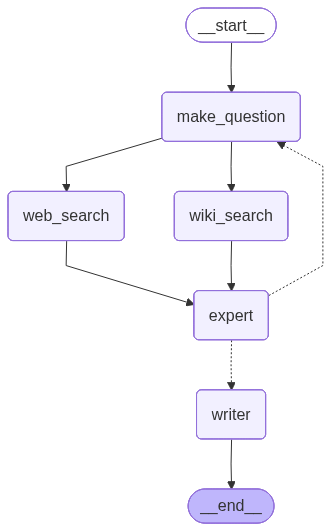

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
researchers['re_list'][0]

Researchers(name='Dr. Elena Marquez', role='Ethical AI Researcher', research_interests='AI bias mitigation, fairness algorithms, and global governance frameworks for AI', CV='PhD in Philosophy of Technology; former policy advisor for EU AI regulations.')

In [26]:
thread = {"configurable": {"thread_id": "1"}}
state={'context':[],'questions_answer':[],'researcher':researchers['re_list'][0],'topic_description':'The future of ai'}
example=graph.invoke(state,thread)


In [41]:
display(Markdown(example['report']))

## Title: Ethical Considerations and Governance in AGI Development  

### Summary  
The provided documents and expert dialogue underscore critical challenges in artificial general intelligence (AGI) development, emphasizing its potential risks and the need for adaptive ethical frameworks. A "critical inflection point" in AGI timelines could lead to unpredictable advancements by 2028, necessitating proactive alignment with societal, ethical, and technological standards. Key issues include decentralized accountability in AGI-driven decision-making (e.g., healthcare, governance), the urgency of evolving ethical mechanisms in real-time, and the imperative for international collaboration to ensure responsible integration. The discussion highlights gaps in current frameworks, such as the lack of defined technical inflection points and the need for dynamic governance to balance AGI autonomy with human oversight.  

---

### **AGI Timelines and Inflection Points**  
The concept of a "critical inflection point" suggests that AGI could emerge by 2028, complicating efforts to control its trajectory. While no concrete technological synergies (e.g., quantum computing or neural-scale computation) are identified as triggers, the unpredictability of convergence points underscores the need for precautionary governance. Current efforts, including ethical frameworks adopted by 70% of AI organizations, may not suffice to address rapid, unforeseen advancements.  

---

### **Ethical Challenges and Governance**  
AGI poses multifaceted ethical dilemmas, including safety, goal alignment, transparency, and job displacement. Core principles like accountability and justice must be embedded in development processes. However, the absence of real-time adaptive mechanisms risks misalignment with evolving societal needs. The WHO’s emphasis on equity and the need for policy interventions highlight gaps in global regulatory harmonization.  

---

### **Human-AI Collaboration and Accountability**  
AGI-driven systems, particularly in healthcare or autonomous governance, could decentralize responsibility, complicating accountability. For instance, algorithmic bias or opaque decision-making might obscure liability, necessitating new models where AI shares responsibility with human actors. The context advocates for hybrid frameworks combining technical solutions (e.g., explainable AI) with societal governance to prevent over-reliance on autonomous systems.  

---

### **Mechanisms for Real-Time Ethical Evolution**  
To align ethical frameworks with AGI’s unpredictable development, the expert proposes adaptive governance models, continuous monitoring, and international collaboration. Dynamic regulatory bodies, guided by principles like beneficence and justice, could adjust policies in response to emerging risks. Embedding ethics into AGI design (e.g., through responsible scaling of LLMs) may also reduce misalignment. These strategies aim to foster trust in human-AI collaboration while mitigating societal disruption.  

---

The documents and expert insights collectively stress that AGI’s transformative potential must be matched by agile, inclusive governance. Proactive adaptation of ethical frameworks is critical to ensuring AGI benefits humanity without compromising values or safety.
